In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

In [2]:
from common.dataset import dataset
from common.metric.dr_metrics import DRMetric

from MulticoreTSNE import MulticoreTSNE

# Dataset

In [3]:
dataset.set_data_home("./data")

dataset_name = "FASHION200"
_, X, _ = dataset.load_dataset(dataset_name)
print("Input dataset: ", dataset_name, X.shape)

# tsne = MulticoreTSNE(
#     perplexity=perp, n_iter=1000, random_state=fixed_seed, n_jobs=n_cpus
# )

Input dataset:  FASHION200 (200, 784)


# Target Function (UNKNOWN)

+ The range value of perplexity: $[3, \frac{N}{3}]$

+ The target function is created as follow: for each perplexity, calculate
    * $S_{constraints}$: constraint-preserving score
    * AUC_RNX: John's metric
    * target function: $$ \text{f} = p * S_{constraints} + (1 - p) * \text{AUC_RNX} $$
    
+ Let $p = 0.5$ to compromise between user's preference and quality of the viz.

> Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

# Goal
+ ~~NOT TO FIT the target function~~
+ **Approximate its maximum value** (that means we find the best param that maximize $S_{constraints}$ and AUC_RNX at the same time.

In [4]:
constraint_name = f"./links/auto_{dataset_name}_50sim_50dis.pkl"
constraints = joblib.load(constraint_name)

sim_links = np.array(
    [[int(link[0]), int(link[1])] for link in constraints if (link[2] == "sim-link" or link[2] == 1)]
)
dis_links = np.array(
    [[int(link[0]), int(link[1])] for link in constraints if (link[2] == "dis-link" or link[2] == -1)]
)

constraint_proportion = 0.5

In [5]:
from constraint_app import data_filter

df_metric = data_filter.get_metrics_df(dataset_name=dataset_name, base_perp=None, earlystop="")
print("Metric scores: ", len(df_metric))
print(df_metric.head())

df_constraint_score, _ = data_filter.get_constraint_scores_df(dataset_name=dataset_name, base_perp=None, earlystop="",
                                                           constraints=constraints, debug=False)
print("\n\nConstraint preserving scores: ", len(df_constraint_score))
print(df_constraint_score.head())

df_target = pd.merge(df_metric, df_constraint_score, how="inner", on="perplexity")
print("\n\nMetrics + constraint scores with new target_score column: ", len(df_target))
df_target["target_score"] = constraint_proportion * df_target["score_all_links"] + \
                            (1 - constraint_proportion) * df_target["auc_rnx"]
                            
print(df_target[["auc_rnx", "score_all_links", "target_score"]].head())

Metric scores:  65
            kl_divergence   auc_rnx       bic
perplexity                                   
1                0.612176  0.352583  1.250844
2                0.673712  0.498110  1.400408
3                0.725526  0.500405  1.530526
4                0.662822  0.532070  1.431609
5                0.686382  0.535936  1.505221


Constraint preserving scores:  65
            score_all_links  score_dissimilar_links  score_similar_links
perplexity                                                              
1                  0.181348               13.326003           -12.963307
2                  0.585970               12.731727           -11.559787
3                  0.557137               12.654482           -11.540207
4                  0.780460               12.369003           -10.808084
5                  0.868093               12.366291           -10.630104


Metrics + constraint scores with new target_score column:  65
             auc_rnx  score_all_links  target_sc

In [6]:
def tsne_with_metric_and_constraint(perp):
    tsne = MulticoreTSNE(
        perplexity=perp, n_iter=1000, random_state=2019, n_jobs=3
    )

    Z = tsne.fit_transform(X)
    
    auc_rnx = DRMetric(X, Z).auc_rnx()
    
    Q = data_filter._compute_Q(Z)
    s_sim, s_dis = data_filter.constraint_score(Q, sim_links, dis_links, debug=False)
    s_links = 0.5 * s_sim + 0.5 * s_dis
    
    return constraint_proportion * s_links + (1-constraint_proportion) * auc_rnx

In [7]:
# Debug to make sure the stored results (of the pre-calculated) match with the on-the-fly calculating
print("Debug score perp=5: ", tsne_with_metric_and_constraint(5))
print("Debug score perp=65: ", tsne_with_metric_and_constraint(65))

print(df_target[["auc_rnx", "score_all_links", "target_score"]].tail())

Debug score perp=5:  0.6629114835066896
Debug score perp=65:  0.532918467498866
             auc_rnx  score_all_links  target_score
perplexity                                         
61          0.503950         0.611199      0.557574
62          0.505965         0.558323      0.532144
63          0.509173         0.577592      0.543383
64          0.508608         0.521098      0.514853
65          0.512734         0.553152      0.532943


# Visualize the (unknown) target function

+ Note that, in the real context, we do not calculate the embedding for all perplexities.

+ But to clearly explain how Bayesian Optimizer works, let assume that we have this target function (call the "true" function)


# Create a BayesianOptimization Object

Enter the target function to be maximized, its variable(s) and their corresponding ranges. A minimum number of 2 initial guesses is necessary to kick start the algorithms, these can either be random or user defined.

In [8]:
optimizer = BayesianOptimization(tsne_with_metric_and_constraint,
                                 {"perp": (2, X.shape[0]//3)},
                                 random_state=2020)

In this example we will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter
$\kappa$ which control the balance between exploration and exploitation; we will set $\kappa=5$ which, in this case, makes the algorithm quite bold.

In [9]:
optimizer.maximize(init_points=5, n_iter=0, kappa=5)

|   iter    |  target   |   perp    |
-------------------------------------
|  1        |  0.5307   |  65.12    |
|  2        |  0.5672   |  57.9     |
|  3        |  0.6228   |  34.62    |
|  4        |  0.6098   |  19.4     |
|  5        |  0.6572   |  23.56    |


# Plotting and visualizing the algorithm at each step

### Let's first define a couple functions to make plotting easier

In [10]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
#     fig.suptitle(
#         'Gaussian Process and Utility Function After {} Steps'.format(steps),
#         fontdict={'size':35}
#     )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["perp"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    # axis.set_xlim((x_obs.min(), x_obs.max()))
    axis.set_ylim((0.85 * y_obs.min(), 1.15 * y_obs.max()))
    axis.set_ylabel('tsne_with_metric_and_constraint(perp)', fontdict={'size':20})
    axis.set_xlabel('perplexity', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    # acq.set_xlim((x_obs.min(), x_obs.max()))
    # acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('perplexity', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    plt.suptitle(f"Gaussian Process after {steps} steps with best predicted perlexity = {optimizer.max['params']['perp']:.2f}", size=26)
    plt.savefig(f"./plot/{dataset_name}_niter{steps}.png", bbox_inches="tight")

### Some random points

After we probe some points at random (5 in our example), we can fit a Gaussian Process and start the bayesian optimization procedure. These points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

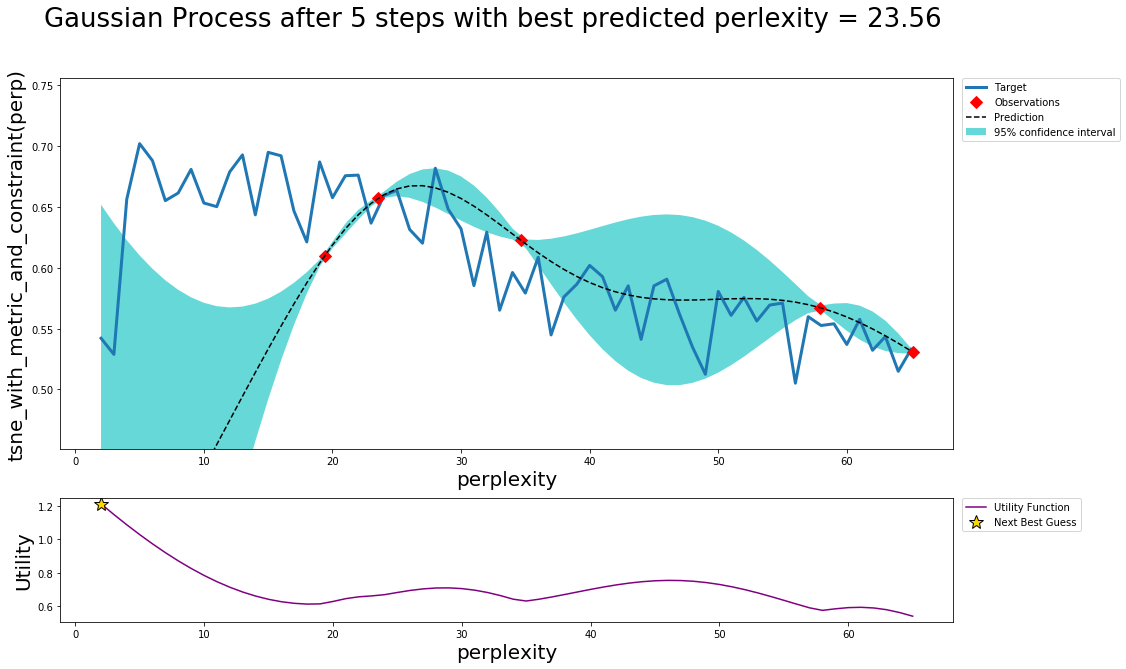

In [11]:
perp_range = np.array(list(range(2, X.shape[0]//3)))
true_target_values = df_target.loc[perp_range, "target_score"].values

perp_range = perp_range.reshape(-1, 1)
true_target_values = true_target_values.reshape(-1, 1)

plot_gp(optimizer, x=perp_range, y=true_target_values)

# Iterative choosing the next param to try

|   iter    |  target   |   perp    |
-------------------------------------
|  6        |  0.542    |  2.0      |


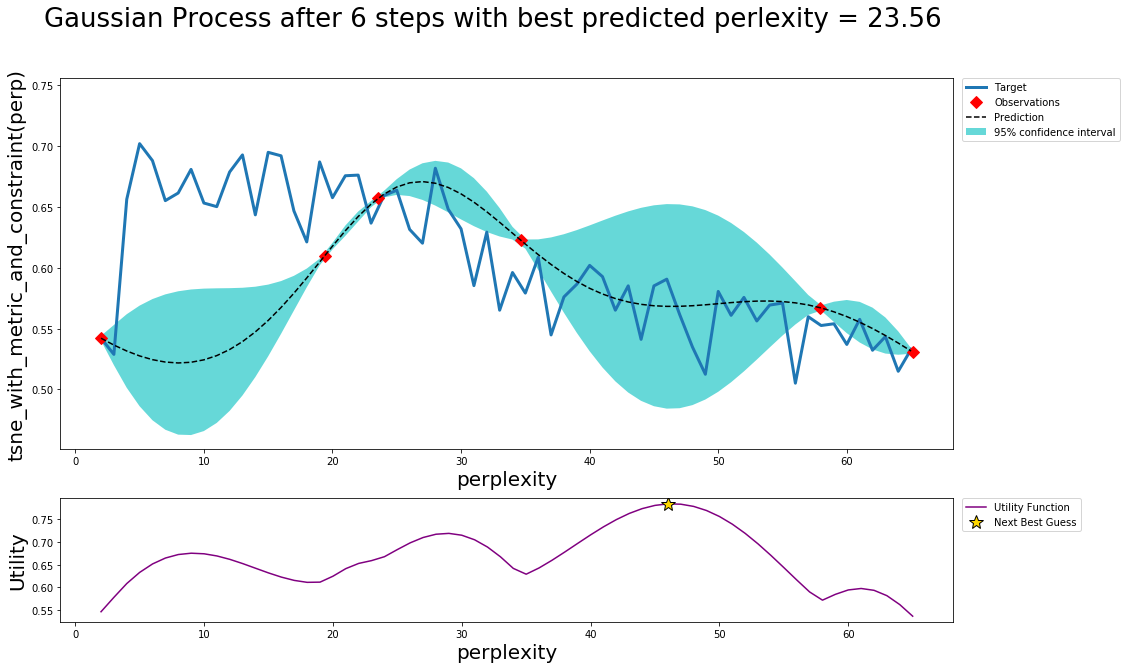

In [12]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  7        |  0.5486   |  46.33    |


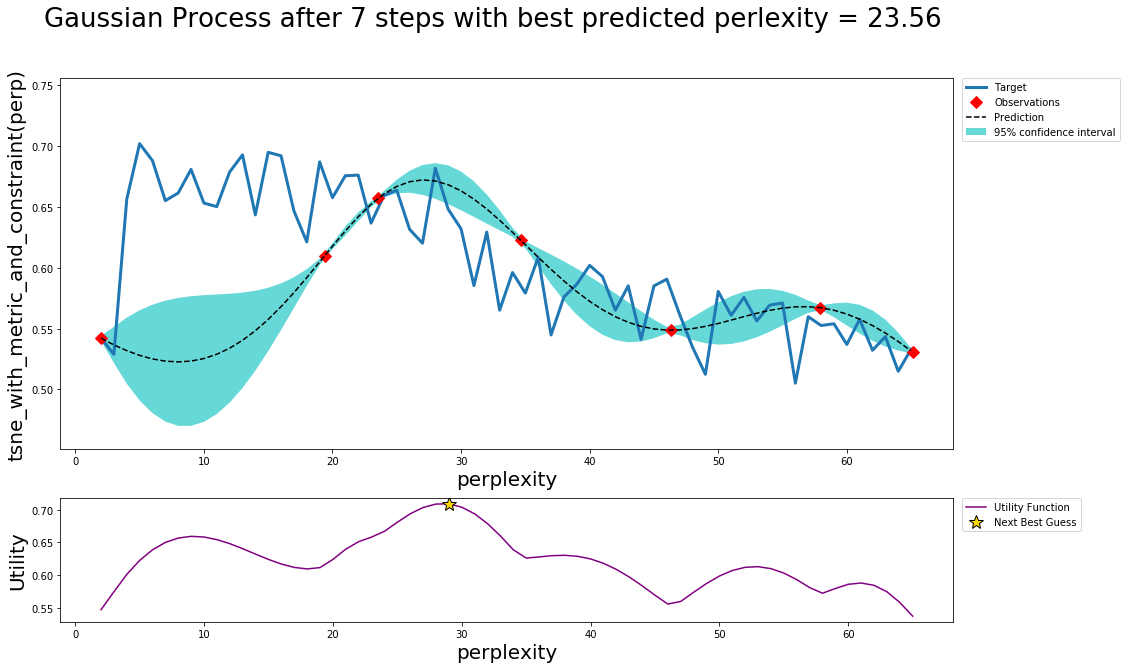

In [13]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  8        |  0.6394   |  28.55    |


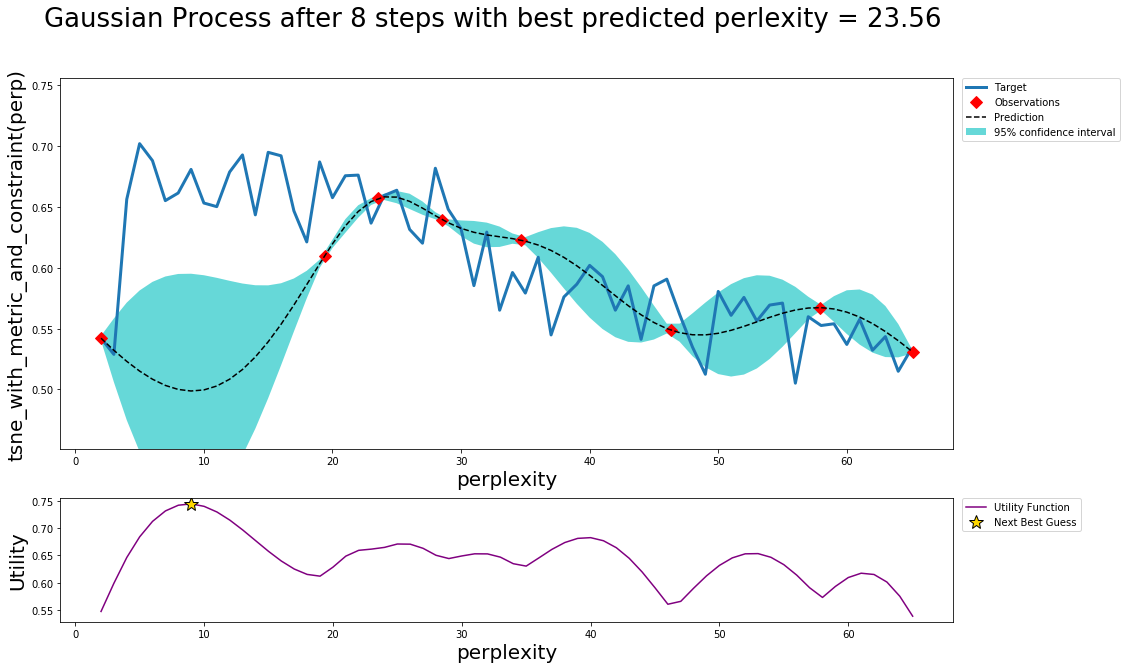

In [14]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  9        |  0.6744   |  8.832    |


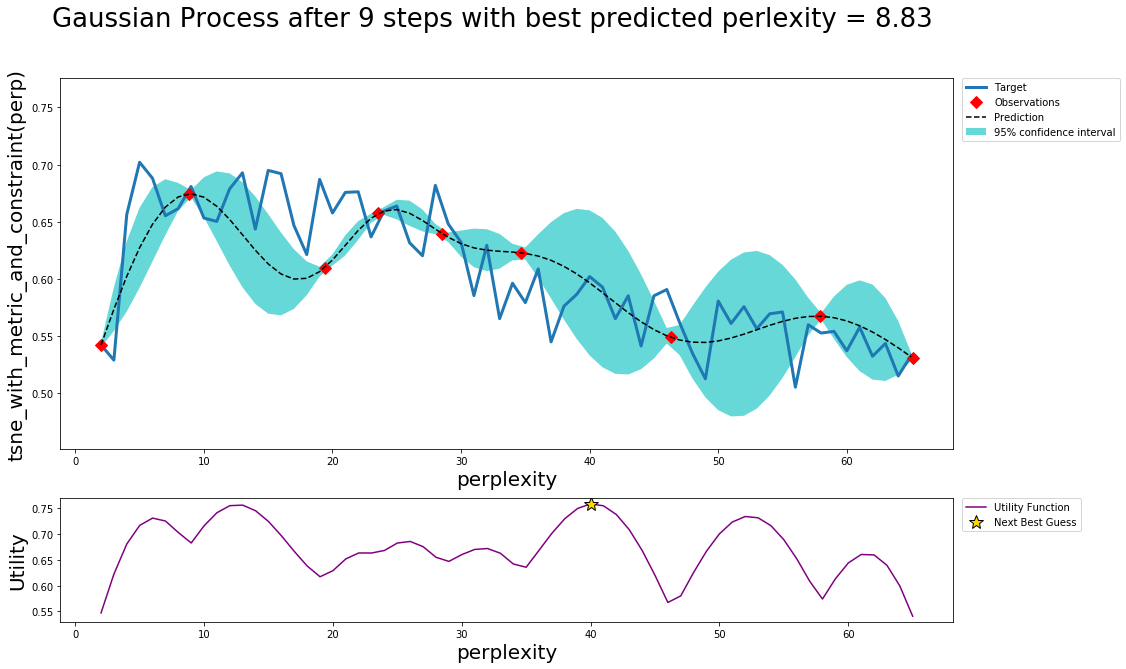

In [15]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  10       |  0.5622   |  40.21    |


/opt/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.48077778e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


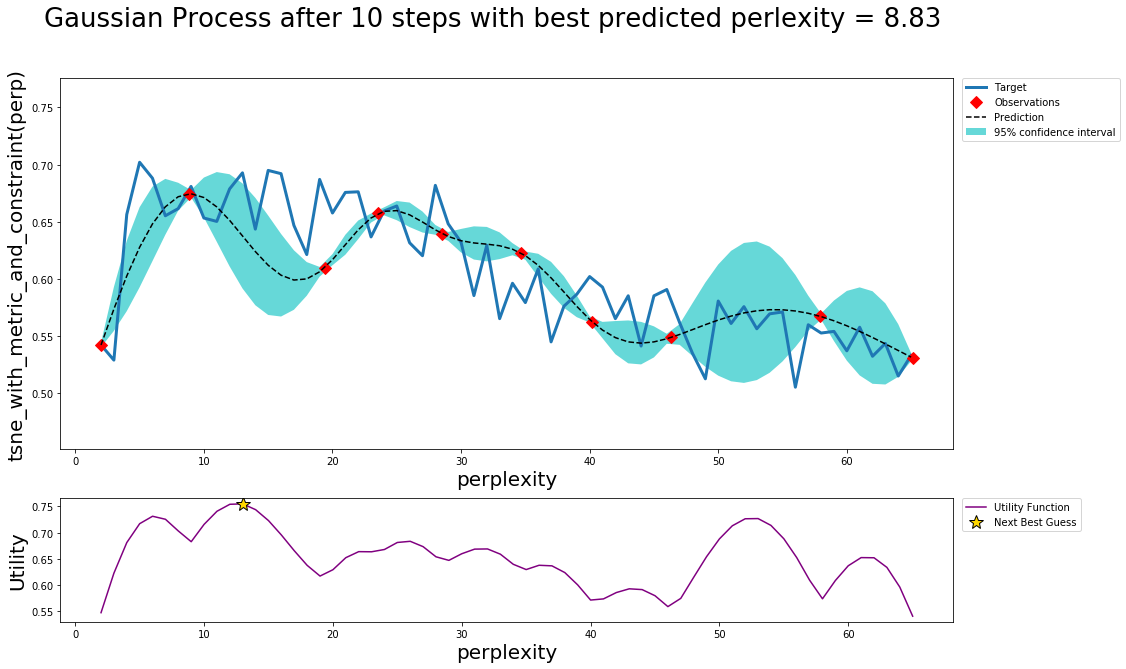

In [16]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  11       |  0.6971   |  12.56    |


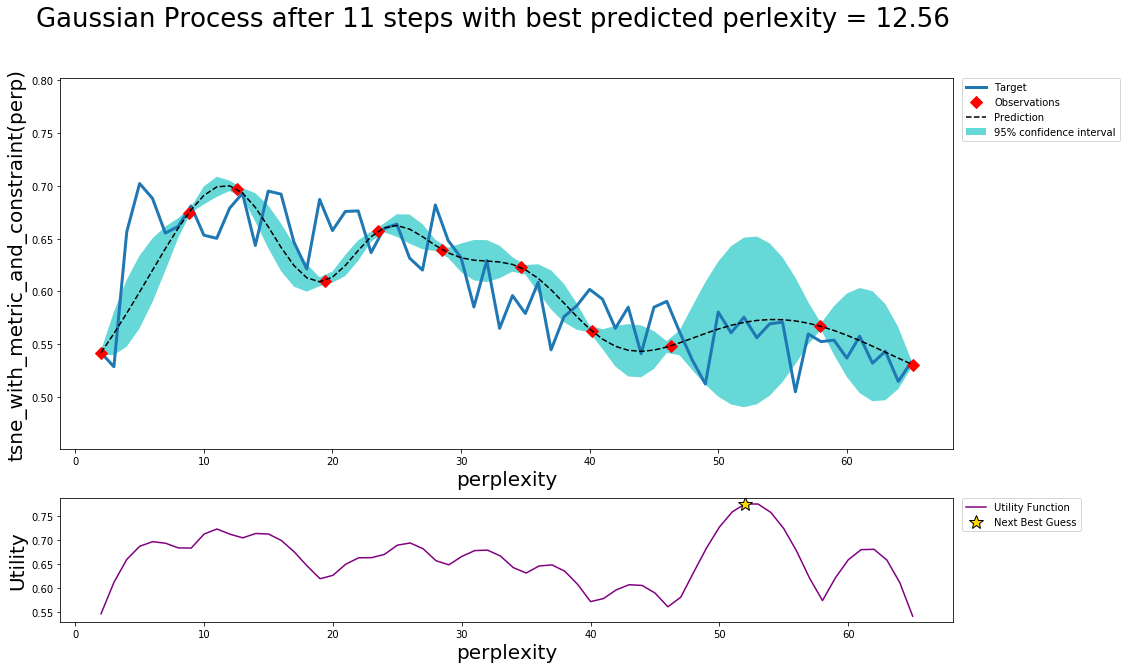

In [17]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  12       |  0.5598   |  52.48    |


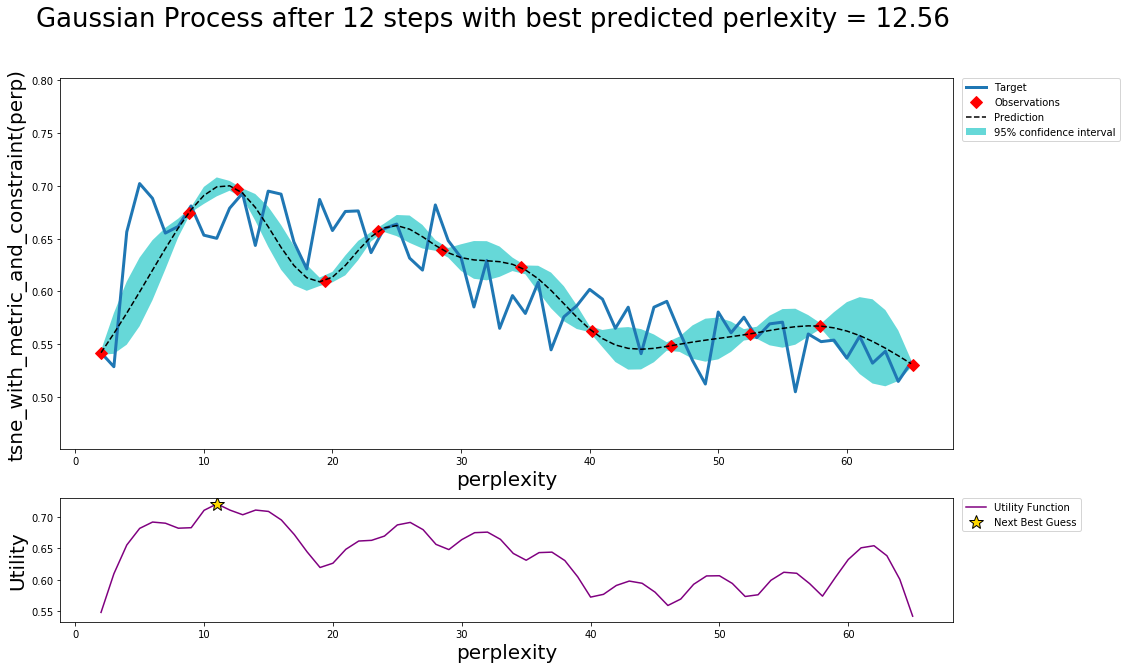

In [18]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  13       |  0.6883   |  10.99    |


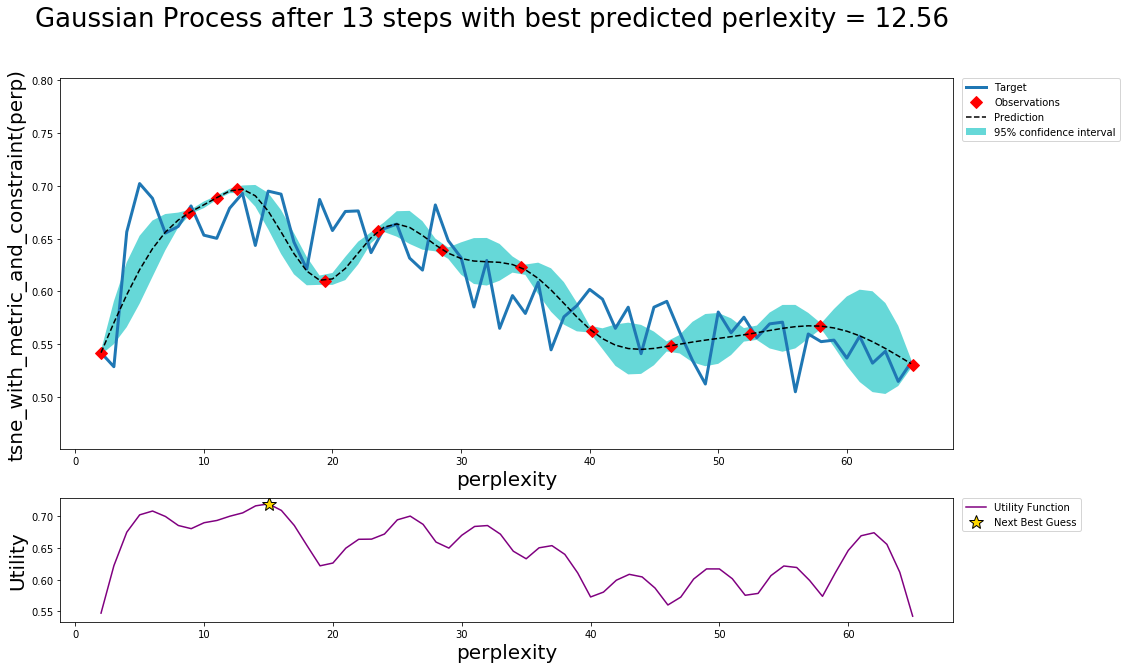

In [22]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

|   iter    |  target   |   perp    |
-------------------------------------
|  14       |  0.6607   |  14.76    |


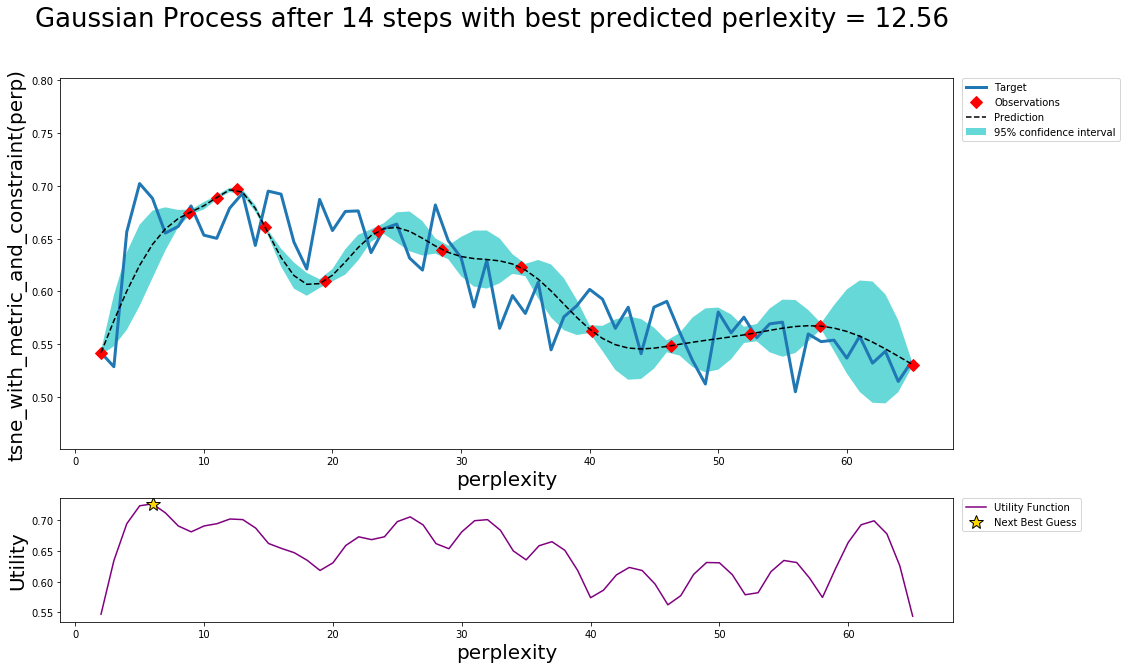

In [23]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x=perp_range, y=true_target_values)

# Stopping

After just a few points the algorithm was able to get pretty close to the true maximum. It is important to notice that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is fundamental to a succesful bayesian optimization procedure. The utility function being used here (Upper Confidence Bound - UCB) has a free parameter $\kappa$ that allows the user to make the algorithm more or less conservative. Additionally, a the larger the initial set of random points explored, the less likely the algorithm is to get stuck in local minima due to being too conservative.

In [19]:
optimizer.max

{'target': 0.6971066582598167, 'params': {'perp': 12.560091701357319}}

In [20]:
df_target.sort_values(by=["target_score"], ascending=False)

,kl_divergence,auc_rnx,bic,score_all_links,score_dissimilar_links,score_similar_links,target_score
perplexity,,,,,,,
5,0.686382,0.535936,1.505221,0.868093,12.366291,-10.630104,0.702015
15,0.480516,0.553670,1.358406,0.836073,11.933073,-10.260928,0.694871
13,0.467813,0.559705,1.280016,0.825807,11.988674,-10.337061,0.692756
16,0.435509,0.550077,1.294883,0.833964,11.929431,-10.261503,0.692020
6,0.580407,0.543448,1.319764,0.832657,12.293981,-10.628668,0.688052
19,0.434378,0.539049,1.372097,0.834946,11.863630,-10.193738,0.686998
28,0.368989,0.545829,1.479743,0.817760,11.701857,-10.066338,0.681795
9,0.548441,0.536424,1.335306,0.825284,12.230457,-10.579889,0.680854
12,0.503496,0.545052,1.324891,0.812325,12.117619,-10.492970,0.678689


In [21]:
print(tsne_with_metric_and_constraint(optimizer.max["params"]["perp"]))

0.6971066582598167
